# Inventory Optimization Experimentation
Using OpenAI's gymnasium, create a custom environment that simulates a simple supply chain system of distribution centers, stores, products, and customer demand.  

**References:**  
[or-gym](https://github.com/hubbs5/or-gym)

First, visualize a very simple supply chain network consisting of:
1. 100 products
2. 15 stores w/ demand
3. 2 distribution centers
4. 3 manufacturers
5. Raw materials

In [98]:
SEED = 77
N_ITEMS = 100

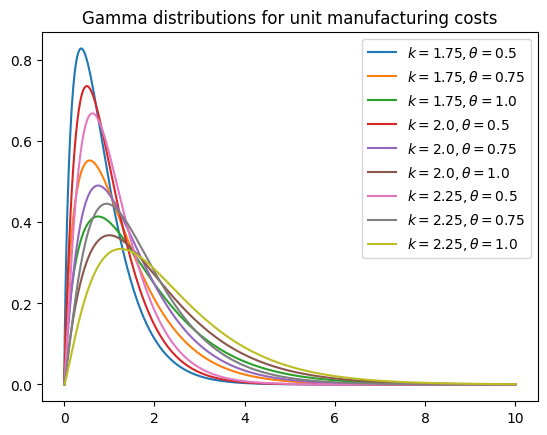

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# (shape, scale)
params = [
    [1.75, 0.5],
    [1.75, 0.75],
    [1.75, 1.],
    [2., 0.5],
    [2., 0.75],
    [2., 1.],
    [2.25, 0.5],
    [2.25, 0.75],
    [2.25, 1.],
]

x = np.linspace(0, 10, 1000)

for param in params:
    y = stats.gamma.pdf(x, a=param[0], scale=param[1])
    plt.plot(x, y, label=r'$k={}, \theta={}$'.format(param[0], param[1]))

plt.legend(loc='upper right')
plt.title('Gamma distributions for unit manufacturing costs')
plt.show()

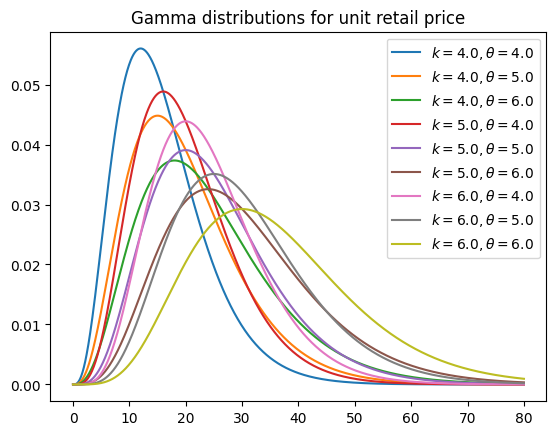

In [126]:
# (shape, scale)
params = [
    [4., 4.],
    [4., 5.],
    [4., 6.],
    [5., 4.],
    [5., 5.],
    [5., 6.],
    [6., 4.],
    [6., 5.],
    [6., 6.]
]

x = np.linspace(0, 80, 1000)

for param in params:
    y = stats.gamma.pdf(x, a=param[0], scale=param[1])
    plt.plot(x, y, label=r'$k={}, \theta={}$'.format(param[0], param[1]))

plt.legend(loc='upper right')
plt.title('Gamma distributions for unit retail price')
plt.show()

In [99]:
from dataclasses import dataclass

@dataclass
class Item:
    '''Object for tracking items in an inventory system'''
    id: int
    unit_manufacturing_cost: float
    unit_retail_price: float
    quantity: int
   

In [105]:
def generate_random_items(
        rng, 
        n_items, 
        umc_gamma_shape=2, 
        umc_gamma_scale=0.5,
        urp_gamma_shape=5,
        urp_gamma_scale=5,
        quant_normal_loc=50000, 
        quant_normal_scale=10000
    ):

    ids = rng.choice(np.arange(start=1000000, stop=9999999), size=n_items, replace=False)
    umcs = rng.gamma(shape=umc_gamma_shape, scale=umc_gamma_scale, size=n_items).round(decimals=2)
    urps = rng.gamma(shape=urp_gamma_shape, scale=urp_gamma_scale, size=n_items).round(decimals=2)
    quants = rng.normal(loc=quant_normal_loc, scale=quant_normal_scale, size=n_items).round(decimals=-1).clip(min=0).astype(int)

    return [Item(ids[i], umcs[i], urps[i], quants[i]) 
            for i in range(N_ITEMS)]

In [129]:
rng = np.random.default_rng(SEED)

items = generate_random_items(rng, 500)
item_ids = [item.id for item in items]

In [36]:
@dataclass
class Store:
    id: int 
    lat: float
    long: float
    cap: int
    item_ids: 

In [128]:
@dataclass
class DC:
    id: int
    lat: float
    long: float
    cap: int

In [38]:
@dataclass
class Manufacturer:
    id: int
    lat: float
    long: float
    cap: int

In [10]:
import networkx as nx

graph = nx.DiGraph()

Node Definitions:
* I0: Initial inventory
* h: Unit holding cost for excess on-hand inventory
* C: Production capacity
* v: Production yield (0, 1]
* o: Unit operating cost

In [12]:
# Nodes
graph.add_nodes_from([0]) # Market/demand
graph.add_nodes_from([1], I0=100, h=0.03) # Store 1
graph.add_nodes_from([2], I0=80, h=0.035) # Store 2
graph.add_nodes_from([3], I0=20, h=0.028) # Store 3
graph.add_nodes_from([4], I0=100, h=0.03) # Store 4
graph.add_nodes_from([5], I0=80, h=0.035) # Store 5
graph.add_nodes_from([6], I0=20, h=0.028) # Store 6
graph.add_nodes_from([7], I0=10000, h=0.01) # DC1
graph.add_nodes_from([8], I0=8000, h=0.02) # DC2
graph.add_nodes_from([9], I0=500, C=90, o=0.01, v=1.0, h=0.012) # Manufacturer 1
graph.add_nodes_from([10], I0=320, C=90, o=0.015, v=1.0, h=0.013) # Manufacturer 2
graph.add_nodes_from([11], I0=410, C=80, o=0.012, v=1.0, h=0.011) # Manufacturer 3
graph.add_nodes_from([12,13]) # Raw materials

Edge definitions:
* L: Lead time
* p: Unit price to send units (purchase price or reorder cost)
* b: Unit cost of unfulfilled demand
* g: Unit holding cost for pipeline inventory
* demand_dist: Probability distribution for demand

In [13]:
from scipy.stats import poisson

# Edges
graph.add_edges_from(
    [
        (1, 0, {'p': 18.0, 'b': 3, 'demand_dist': poisson, 'dist_param': {'mu': 15}}),
        (2, 0, {'p': 18.0, 'b': 3, 'demand_dist': poisson, 'dist_param': {'mu': 18}}),
        (3, 0, {'p': 18.0, 'b': 3, 'demand_dist': poisson, 'dist_param': {'mu': 5}}),
        (4, 0, {'p': 18.0, 'b': 3, 'demand_dist': poisson, 'dist_param': {'mu': 19}}),
        (5, 0, {'p': 18.0, 'b': 3, 'demand_dist': poisson, 'dist_param': {'mu': 25}}),
        (6, 0, {'p': 18.0, 'b': 3, 'demand_dist': poisson, 'dist_param': {'mu': 21}}),
        (7, 1, {'L': 2, 'p': 3.5, 'g': 0.03}),
        (7, 2, {'L': 2, 'p': 3.5, 'g': 0.009}),
        (7, 4, {'L': 4, 'p': 4.2, 'g': 0.021}),
        (7, 5, {'L': 5, 'p': 4.3, 'g': 0.016}),
        (8, 1, {'L': 6, 'p': 6.0, 'g': 0.006}),
        (8, 2, {'L': 6, 'p': 6.0, 'g': 0.034}),
        (8, 3, {'L': 1, 'p': 1.0, 'g': 0.011}),
        (8, 4, {'L': 4, 'p': 2.0, 'g': 0.027}),
        (8, 5, {'L': 3, 'p': 1.75, 'g': 0.009}),
        (8, 6, {'L': 2, 'p': 1.4, 'g': 0.004}),
        (9, 7, {'L': 8, 'p': 1.25, 'g': 0.003}),
        (9, 8, {'L': 9, 'p': 1.37, 'g': 0.002}),
        (10, 7, {'L': 6, 'p': 1.8, 'g': 0.004}),
        (10, 8, {'L': 6, 'p': 1.7, 'g': 0.005}),
        (11, 7, {'L': 14, 'p': 1.4, 'g': 0.001}),
        (11, 8, {'L': 15, 'p': 1.6, 'g': 0.001}),
        (12, 9, {'L': 1, 'p': 0.9, 'g': 0.002}),
        (12, 10, {'L': 2, 'p': 0.75, 'g': 0.001}),
        (12, 11, {'L': 3, 'p': 0.6, 'g': 0.002}),
        (13, 9, {'L': 3, 'p': 1.25, 'g': 0.001}),
        (13, 10, {'L': 2, 'p': 1.44, 'g': 0.001}),
        (13, 11, {'L': 1, 'p': 1.9, 'g': 0.0})
    ]
)

In [14]:
n_nodes = graph.number_of_nodes()

In [31]:
import numpy as np

levels = {}
levels['store'] = np.arange(start=1, stop=7)
levels['dc'] = np.unique(np.hstack([list(graph.predecessors(i)) for i in levels['store']]))
levels['manufacturer'] = np.unique(np.hstack([list(graph.predecessors(i)) for i in levels['dc']]))
levels['raw'] = np.unique(np.hstack([list(graph.predecessors(i)) for i in levels['manufacturer']]))
levels.items()

dict_items([('store', array([1, 2, 3, 4, 5, 6])), ('dc', array([7, 8])), ('manufacturer', array([ 9, 10, 11])), ('raw', array([12, 13]))])

In [32]:
import matplotlib.pyplot as plt

def plot_network(graph, levels):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    adjacency_matrix = np.vstack(graph.edges())
    level_col = {
        'store': 0,
        'dc': 1,
        'manufacturer': 2,
        'raw': 3
    }
    max_density = np.max([len(v) for v in levels.values()])
    node_coords = {}
    node_num = 1
    plt.figure(figsize=(12, 8))
    # Draw nodes
    for i, (level, nodes) in enumerate(levels.items()):
        n = len(nodes)
        node_y = max_density / 2 if n == 1 else np.linspace(0, max_density, n)
        node_y = np.atleast_1d(node_y)
        plt.scatter(np.repeat(i, n), node_y, label=level, s=50)
        for y in node_y:
            plt.annotate(f'$N_{node_num}$', xy=(i, y+0.05))
            node_coords[node_num] = (i, y)
            node_num += 1
    # Draw edges
    for node_num, v in node_coords.items():
        x, y = v
        sinks = adjacency_matrix[np.where(adjacency_matrix[:, 0]==node_num)][:, 1]
        for s in sinks:
            try:
                sink_coord = node_coords[s]
            except KeyError:
                continue
            for k, n in levels.items():
                if node_num in n:
                    color = colors[level_col[k]]
            x_ = np.hstack([x, sink_coord[0]])
            y_ = np.hstack([y, sink_coord[1]])
            plt.plot(x_, y_, color=color)

    plt.ylabel('Node')
    plt.yticks([0], [''])
    plt.xlabel('Level')
    plt.xticks(np.arange(len(levels)), [k for k in levels.keys()])
    plt.show()


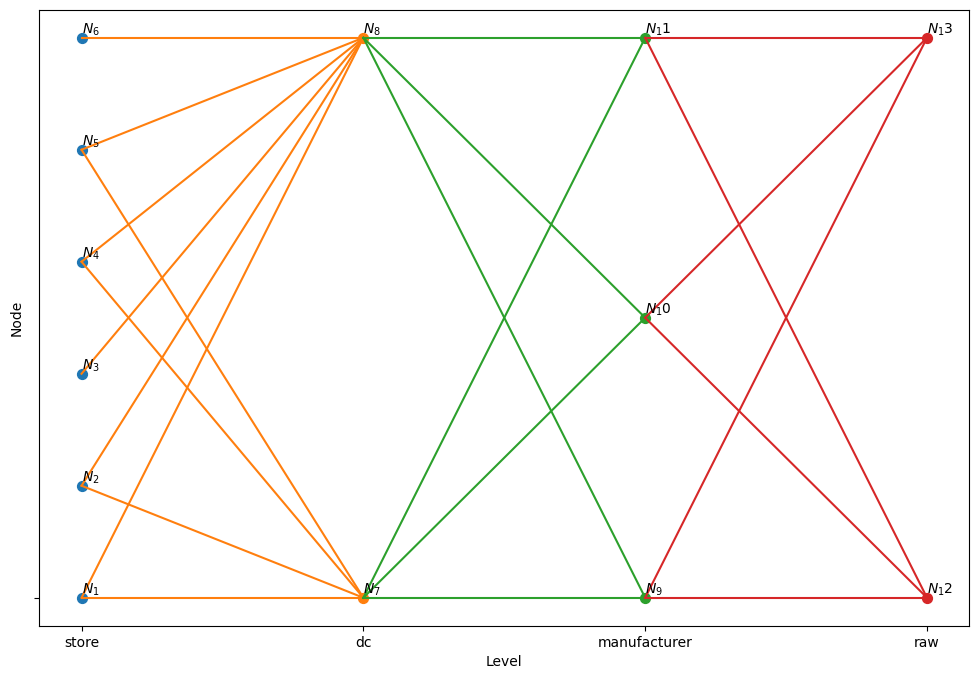

In [33]:
plot_network(graph, levels)

In [ ]:
class InventoryEnv(gym.Env):
    def __init(self):
        self.periods = 30 # Number of periods in simulation
        self.I0 = 